# Dependencies

In [10]:
pacman::p_load(factoextra)

# Functions

# Paths

In [11]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/"

# Main

In [12]:
hla <- xlsx::read.xlsx(file = paste0(datapath, "/HLA/UHN-20230127-B257-HLA.xlsx"), sheetIndex = 1)

In [13]:
hla[ hla$Sample.ID == "396-02",]

,Sample.ID,Locus,Allele.1,Allele.2,Comments,Diploid.Ambiguities,Allele.1.Ambiguities,Allele.2.Ambiguities
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
424,396-02,A,A*03:01:01,A*03:01:01,,,,
425,396-02,B,B*07:02:01,B*18:01:01,,,,
426,396-02,C,C*07:02:01,C*12:03:01,,,,
427,396-02,DPA1,DPA1*01:03:01,DPA1*01:03:01,,,,
428,396-02,DPB1,DPB1*02:01:02,DPB1*04:01:01,,,,
429,396-02,DQA1,DQA1*01:02:01,DQA1*02:01:01,,,,
430,396-02,DQB1,DQB1*02:02:01,DQB1*06:02:01,,,,
431,396-02,DRB1,DRB1*07:01:01,DRB1*15:01:01,,,,
432,396-02,DRB345,DRB4*01:01:01,DRB5*01:01:01,,,,


In [14]:
hlafiles <- list.files(path = paste0(datapath, "/HLA/"), pattern = "INT", full.names = TRUE)

In [15]:
hlafiles <- hlafiles[ hlafiles != "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data//HLA//INT_HLA_PCA_postqc.rds"]

In [16]:
hlas <- lapply(hlafiles, function(x) {
  read.table(x, header = TRUE, sep = "\t", stringsAsFactors = FALSE, check.names = F)
})

Allele frequencies

In [17]:
afs <- lapply(hlas, function(x) {
    n <- colSums(x)
    freq <- colSums(x) / (2 * nrow(x))
    data.frame(type=names(freq), freq, n)
})

In [18]:
lowfreq <- lapply(afs, function(x) {
    subset(x, freq < 0.01 | freq > 0.99)$type
})

In [19]:
lowfreq

[[1]]
 [1] "A*24:25"    "A*02:02:01" "A*02:06:01" "A*68:02:01" "A*36:01:01"
 [6] "A*68:152"   "A*68:10"    "A*26:02:01" "A*02:03:01" "A*80:01:01"
[11] "A*30:04:01" "A*68:03:01"

[[2]]
 [1] "B*41:01:01" "B*35:12:01" "B*15:32:01" "B*35:17:01" "B*14:02:01"
 [6] "B*52:01:02" "B*35:02:01" "B*39:05:01" "B*39:01:01" "B*35:14:01"
[11] "B*35:05:01" "B*50:01:01" "B*56:01:01" "B*39:02:02" "B*58:01:01"
[16] "B*41:02:01" "B*15:16:01" "B*15:17:01" "B*40:02:01" "B*57:03:01"

[[3]]
[1] "C*16:112"   "C*16:02:01" "C*07:18:01" "C*17:03:01" "C*07:01:02"
[6] "C*08:02:01" "C*18:02:01"

[[4]]
[1] "DPA1*01:05"        "DPA1*02:01:07"     "DPA1*01:33:01"    
[4] "DPA1*02:01:02"     "DPA1*01:06:01"     "DPA1*03:01:01"    
[7] "DPA1*02:06"        "DPA1*03:05:01:01Q"

[[5]]
[1] "DPB1*09:01:01"  "DPB1*698:01"    "DPB1*519:01"    "DPB1*124:01:01"
[5] "DPB1*40:01:01"  "DPB1*16:01:01"  "DPB1*14:01:01" 

[[6]]
[1] "DQA1*05:09:01" "DQA1*01:05:01" "DQA1*04:02"    "DQA1*05:03:01"
[5] "DQA1*04:01:02"

[[7]]
[1] "DQB1*04:01:01" "DQB1*03:05:01" "DQB1*05:01:24"

[[8]]
 [1] "DRB1*10:01:01" "DRB1*14:02:01" "DRB1*11:34"    "DRB1*13:03:01"
 [5] "DRB1*08:04:01" "DRB1*04:03:01" "DRB1*13:04"    "DRB1*15:02:02"
 [9] "DRB1*08:02:01" "DRB1*08:06:01" "DRB1*11:03:01"

[[9]]
character(0)

In [20]:
hlas_lowfreqrm <- purrr::map2(hlas, lowfreq, function(x, y) {
    x[, !colnames(x) %in% y]
})

hwe

In [21]:
hwe.fx <- function(x) {
    x <- as.numeric(x)
    # observed counts
    a0 <- length(x[x == 0])
    a1 <- length(x[x == 1])
    a2 <- length(x[x == 2])
    freq <- sum(x) / (2 * length(x))
    # get expected frequencies
    P_a0 <- (1 - freq)^2
    P_a1 <- 2 * (1 - freq) * freq
    P_a2 <- freq^2
    chitest <- chisq.test(c(a0, a1, a2), p = c(P_a0, P_a1, P_a2)) #  Pearson's chi-squared goodness-of-fit test compared to expected frequencies
    chitest$p.value#[chitest$p.value <= 1e-04]
}

In [22]:
hwe_chip <- lapply(hlas_lowfreqrm, function(x) {
    apply(x, 2, hwe.fx) 
})

Warning message in chisq.test(c(a0, a1, a2), p = c(P_a0, P_a1, P_a2)):
"Chi-squared approximation may be incorrect"
Warning message in chisq.test(c(a0, a1, a2), p = c(P_a0, P_a1, P_a2)):
"Chi-squared approximation may be incorrect"
Warning message in chisq.test(c(a0, a1, a2), p = c(P_a0, P_a1, P_a2)):
"Chi-squared approximation may be incorrect"
Warning message in chisq.test(c(a0, a1, a2), p = c(P_a0, P_a1, P_a2)):
"Chi-squared approximation may be incorrect"
Warning message in chisq.test(c(a0, a1, a2), p = c(P_a0, P_a1, P_a2)):
"Chi-squared approximation may be incorrect"
Warning message in chisq.test(c(a0, a1, a2), p = c(P_a0, P_a1, P_a2)):
"Chi-squared approximation may be incorrect"
Warning message in chisq.test(c(a0, a1, a2), p = c(P_a0, P_a1, P_a2)):
"Chi-squared approximation may be incorrect"
Warning message in chisq.test(c(a0, a1, a2), p = c(P_a0, P_a1, P_a2)):
"Chi-squared approximation may be incorrect"
Warning message in chisq.test(c(a0, a1, a2), p = c(P_a0, P_a1, P_a2)):
"

In [23]:
sig_hwe_chip <- lapply( hwe_chip, function(x) x[x <= 1e-04] )

In [24]:
sig_hwe_chip

[[1]]
  A*32:01:01 
2.825757e-15 

[[2]]
named numeric(0)

[[3]]
named numeric(0)

[[4]]
named numeric(0)

[[5]]
DPB1*11:01:01 
 2.825757e-15 

[[6]]
named numeric(0)

[[7]]
named numeric(0)

[[8]]
DRB1*11:04:01 
 4.798108e-07 

[[9]]
named numeric(0)

In [25]:
hlas_lowfreqrm_hwe <- purrr::map2(hlas_lowfreqrm, sig_hwe_chip, function(x, y) {
    x[, !colnames(x) %in% names(y)]
})

In [26]:
lapply(hlas_lowfreqrm_hwe, function(x)dim(x))

[[1]]
[1] 67 16

[[2]]
[1] 67 21

[[3]]
[1] 67 15

[[4]]
[1] 67  4

[[5]]
[1] 67 16

[[6]]
[1] 67 13

[[7]]
[1] 67 15

[[8]]
[1] 67 22

[[9]]
[1] 67 12

In [27]:
allhlas <- hlas_lowfreqrm_hwe[[1]]

In [28]:
for(i in 2:length(hlas_lowfreqrm_hwe)){
x <- hlas_lowfreqrm_hwe[[i]]
x <- x[rownames(allhlas),] # make sure the same rows are in the same order
allhlas <- cbind(allhlas, x)
}

In [29]:
head(allhlas)

,A*02:01:01,A*01:01:01,A*11:01:01,A*26:01:01,A*31:01:02,A*03:01:01,A*02:05:01,A*23:01:01,A*24:02:01,A*30:01:01,...,DRB345*Not_Present,DRB5*01:01:01,DRB4*01:03:01,DRB3*03:01:01,DRB4*01:01:01,DRB3*01:62:01,DRB4*01:03:02,DRB5*02:02:01,DRB5*01:02:01,DRB4*01:03:01:02N
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
315-05,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
319-05,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
323-03,0,0,1,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
329-04,0,0,0,2,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
330-05,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
331-04,1,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0


LD pruning

In [30]:
cormat <- cor(allhlas)

remove <- c()
for( i in 1:ncol(allhlas) ){    
    if( is.element(i, remove) ){ next } else {
        r2 <- cormat[,i]^2
        ldmarker <- ( 1:ncol(allhlas) )[ r2 > 0.5 ]
        ldmarker <- setdiff(ldmarker, i) #keep self
        remove <- c(remove, ldmarker)
    }
}

In [31]:
cormat[remove,remove, drop = F]

,B*08:01:01,C*07:04:01,DPB1*01:01:02,DRB1*04:07:01,C*07:02:01,C*12:03:01,C*02:02:02,C*17:01:01,C*02:10:01,C*03:04:01,...,DRB1*09:01:02,DRB4*01:03:02,DRB1*11:01:02,DRB1*13:02:01,DRB3*03:01:01,DQB1*04:02:01,DRB3*01:62:01,DRB5*01:02:01,DQB1*05:01:01,DQB1*02:02:01
B*08:01:01,1.00000000,-0.08606630,-0.08606630,-0.08606630,-0.10474044,-0.243440571,0.14791073,-0.10622957,-0.08606630,-0.082597366,...,-0.13933620,-0.10622957,-0.08606630,-0.15388118,-0.15388118,0.079190896,-0.08606630,-0.08606630,-0.066507516,0.023073301
C*07:04:01,-0.08606630,1.00000000,-0.03076923,-0.03076923,0.14411534,0.107338853,-0.04981355,-0.03797773,-0.03076923,-0.069098016,...,-0.04981355,-0.03797773,-0.03076923,-0.05501347,-0.05501347,-0.059914469,-0.03076923,0.48461538,0.125571470,-0.097022155
DPB1*01:01:02,-0.08606630,-0.03076923,1.00000000,-0.03076923,-0.07045639,-0.087031502,-0.04981355,-0.03797773,-0.03076923,-0.069098016,...,-0.04981355,-0.03797773,0.48461538,-0.05501347,-0.05501347,-0.059914469,-0.03076923,-0.03076923,0.125571470,0.074043224
DRB1*04:07:01,-0.08606630,-0.03076923,-0.03076923,1.00000000,-0.07045639,0.107338853,0.28393722,-0.03797773,-0.03076923,0.188100155,...,-0.04981355,-0.03797773,-0.03076923,-0.05501347,-0.05501347,-0.059914469,-0.03076923,-0.03076923,-0.090153876,-0.097022155
C*07:02:01,-0.10474044,0.14411534,-0.07045639,-0.07045639,1.00000000,-0.037441907,-0.11406469,-0.08696264,-0.07045639,-0.158222889,...,-0.11406469,-0.08696264,-0.07045639,-0.12597163,-0.12597163,-0.017817416,-0.07045639,-0.07045639,0.063003587,-0.150944297
C*12:03:01,-0.24344057,0.10733885,-0.08703150,0.10733885,-0.03744191,1.000000000,-0.01502921,-0.10742090,-0.08703150,-0.098446564,...,-0.14089881,-0.10742090,-0.08703150,0.19191518,0.19191518,-0.061331820,-0.08703150,0.10733885,-0.010928674,-0.080884478
C*02:02:02,0.14791073,-0.04981355,-0.04981355,0.28393722,-0.11406469,-0.015029206,1.00000000,-0.06148367,-0.04981355,0.054689831,...,-0.08064516,-0.06148367,-0.04981355,-0.08906352,-0.08906352,-0.096997949,-0.04981355,-0.04981355,-0.006255160,0.064482632
C*17:01:01,-0.10622957,-0.03797773,-0.03797773,-0.03797773,-0.08696264,-0.107420904,-0.06148367,1.00000000,-0.03797773,-0.085286030,...,-0.06148367,-0.04687500,0.38610688,0.18484381,0.18484381,0.161987899,0.38610688,-0.03797773,0.243744744,-0.119752127
C*02:10:01,-0.08606630,-0.03076923,-0.03076923,-0.03076923,-0.07045639,-0.087031502,-0.04981355,-0.03797773,1.00000000,0.188100155,...,-0.04981355,-0.03797773,-0.03076923,0.25214506,0.25214506,-0.059914469,-0.03076923,-0.03076923,0.125571470,0.245108602
C*03:04:01,-0.08259737,-0.06909802,-0.06909802,0.18810015,-0.15822289,-0.098446564,0.05468983,-0.08528603,0.18810015,1.000000000,...,0.05468983,0.12634967,-0.06909802,0.02974182,0.02974182,0.008542797,-0.06909802,0.18810015,0.012854429,-0.047143896


In [32]:
remove <- unique(remove)
keep <- setdiff(1:ncol(allhlas), remove)

allhlas_1 <- allhlas[, keep]
dim(allhlas_1)

[1] 67 93

In [33]:
dim(allhlas)

[1]  67 134

PCA

In [42]:
head(allhlas)

,A*02:01:01,A*01:01:01,A*11:01:01,A*26:01:01,A*31:01:02,A*03:01:01,A*02:05:01,A*23:01:01,A*24:02:01,A*30:01:01,...,DRB345*Not_Present,DRB5*01:01:01,DRB4*01:03:01,DRB3*03:01:01,DRB4*01:01:01,DRB3*01:62:01,DRB4*01:03:02,DRB5*02:02:01,DRB5*01:02:01,DRB4*01:03:01:02N
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
315-05,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
319-05,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
323-03,0,0,1,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
329-04,0,0,0,2,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
330-05,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
331-04,1,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0


In [34]:
mypca <- prcomp(allhlas, scale = TRUE)

In [43]:
mypca

Standard deviations (1, .., p=67):
 [1] 2.863020e+00 2.772147e+00 2.596364e+00 2.536753e+00 2.412534e+00
 [6] 2.348163e+00 2.332498e+00 2.231683e+00 2.126267e+00 2.049167e+00
[11] 2.006945e+00 1.972824e+00 1.935313e+00 1.918639e+00 1.826351e+00
[16] 1.816094e+00 1.783530e+00 1.732868e+00 1.692806e+00 1.594552e+00
[21] 1.536914e+00 1.496324e+00 1.467680e+00 1.432312e+00 1.419881e+00
[26] 1.402535e+00 1.394589e+00 1.365243e+00 1.334104e+00 1.266350e+00
[31] 1.212643e+00 1.178029e+00 1.157019e+00 1.119250e+00 1.098382e+00
[36] 1.061264e+00 1.051624e+00 1.020437e+00 9.854962e-01 9.147695e-01
[41] 8.831029e-01 8.538079e-01 8.319775e-01 8.139000e-01 7.912224e-01
[46] 7.653447e-01 7.301122e-01 7.128048e-01 6.559560e-01 6.258989e-01
[51] 6.206922e-01 6.050147e-01 5.976591e-01 5.597764e-01 5.356421e-01
[56] 5.187471e-01 4.720099e-01 4.531592e-01 4.180347e-01 3.664218e-01
[61] 3.509446e-01 3.391702e-01 3.222660e-01 2.770857e-01 2.435311e-01
[66] 2.080975e-01 1.271436e-15

Rotation (n x k) = (134

In [35]:
out <- mypca$x
mydf <- data.frame(out)

In [41]:
head(out)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67
315-05,1.15890201,-2.898493,-3.4723486,3.3513972,-1.2856095,1.3652377,-0.98814450,0.3025367,-2.4434325,0.7885129,...,-0.71596361,0.04809325,0.31848056,0.3792461,0.48432470,-0.31782748,-0.15632117,0.11953686,0.0143342286,-2.666270e-15
319-05,-4.56374676,-1.367813,2.0296584,-0.8423059,-0.7075454,-2.2932518,1.85458779,0.7702846,-0.5651254,1.6015236,...,0.29018989,0.80729791,0.29301440,0.1399793,0.22943811,-0.69063112,0.19551515,-0.08730404,-0.0411502225,1.908196e-17
323-03,4.29021503,-1.655735,-1.5965245,0.1538018,1.9207118,-1.5288560,3.20844423,-3.1797025,3.5822593,-1.8978836,...,0.03685141,-0.04265836,-0.04030207,-0.1558266,-0.07187716,-0.08719310,-0.01660297,-0.05961457,0.0770658974,1.462372e-15
329-04,-4.25557065,0.314588,-4.4081750,-1.0062229,4.8715689,-0.2699918,-1.20600856,-0.9781981,1.8880483,0.7504148,...,0.84360989,0.10208720,-0.38351856,0.1420335,0.07055897,0.30820487,0.01584124,0.03888392,-0.1613784630,-3.278627e-16
330-05,-0.08941476,-2.768304,2.1200714,-3.4903109,-1.0884092,-1.3053444,-0.04510793,-2.1610084,-0.1333316,1.4136399,...,0.37172788,-0.07073121,0.16185579,0.3380909,0.34679493,0.13256591,-0.01518200,-0.02311564,-0.1974133531,1.115427e-15
331-04,3.44426309,4.036729,0.8425664,-0.1457962,1.5503795,0.8197901,1.79551677,0.8606525,-2.9234943,0.1003881,...,-0.85429907,0.60078922,0.78459363,-0.1427119,0.11234774,0.04738167,-0.21322384,-0.04261676,-0.0001452749,4.631712e-16


In [36]:
summary(mypca)

Importance of components:
                           PC1     PC2     PC3     PC4     PC5     PC6    PC7
Standard deviation     2.86302 2.77215 2.59636 2.53675 2.41253 2.34816 2.3325
Proportion of Variance 0.06117 0.05735 0.05031 0.04802 0.04344 0.04115 0.0406
Cumulative Proportion  0.06117 0.11852 0.16883 0.21685 0.26029 0.30143 0.3420
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     2.23168 2.12627 2.04917 2.00695 1.97282 1.93531 1.91864
Proportion of Variance 0.03717 0.03374 0.03134 0.03006 0.02905 0.02795 0.02747
Cumulative Proportion  0.37920 0.41294 0.44428 0.47434 0.50338 0.53133 0.55880
                          PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     1.82635 1.81609 1.78353 1.73287 1.69281 1.59455 1.53691
Proportion of Variance 0.02489 0.02461 0.02374 0.02241 0.02139 0.01897 0.01763
Cumulative Proportion  0.58370 0.60831 0.63205 0.65446 0.67584 0.69482 0.71244
                          PC22

In [37]:
head(mydf)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
315-05,1.15890201,-2.898493,-3.4723486,3.3513972,-1.2856095,1.3652377,-0.98814450,0.3025367,-2.4434325,0.7885129,...,-0.71596361,0.04809325,0.31848056,0.3792461,0.48432470,-0.31782748,-0.15632117,0.11953686,0.0143342286,-2.666270e-15
319-05,-4.56374676,-1.367813,2.0296584,-0.8423059,-0.7075454,-2.2932518,1.85458779,0.7702846,-0.5651254,1.6015236,...,0.29018989,0.80729791,0.29301440,0.1399793,0.22943811,-0.69063112,0.19551515,-0.08730404,-0.0411502225,1.908196e-17
323-03,4.29021503,-1.655735,-1.5965245,0.1538018,1.9207118,-1.5288560,3.20844423,-3.1797025,3.5822593,-1.8978836,...,0.03685141,-0.04265836,-0.04030207,-0.1558266,-0.07187716,-0.08719310,-0.01660297,-0.05961457,0.0770658974,1.462372e-15
329-04,-4.25557065,0.314588,-4.4081750,-1.0062229,4.8715689,-0.2699918,-1.20600856,-0.9781981,1.8880483,0.7504148,...,0.84360989,0.10208720,-0.38351856,0.1420335,0.07055897,0.30820487,0.01584124,0.03888392,-0.1613784630,-3.278627e-16
330-05,-0.08941476,-2.768304,2.1200714,-3.4903109,-1.0884092,-1.3053444,-0.04510793,-2.1610084,-0.1333316,1.4136399,...,0.37172788,-0.07073121,0.16185579,0.3380909,0.34679493,0.13256591,-0.01518200,-0.02311564,-0.1974133531,1.115427e-15
331-04,3.44426309,4.036729,0.8425664,-0.1457962,1.5503795,0.8197901,1.79551677,0.8606525,-2.9234943,0.1003881,...,-0.85429907,0.60078922,0.78459363,-0.1427119,0.11234774,0.04738167,-0.21322384,-0.04261676,-0.0001452749,4.631712e-16


In [38]:
readr::write_rds(mydf, paste0(datapath, "/HLA/INT_HLA_PCA_postqc.rds"))

In [39]:
p0 <- fviz_pca_ind(mypca,geom = "point", pointshape = 16, pointsize = 2, alpha = 1,
                    ellipse.alpha = 0, invisible="quali",
                       title = "PCA of HLA types (n = 67)")

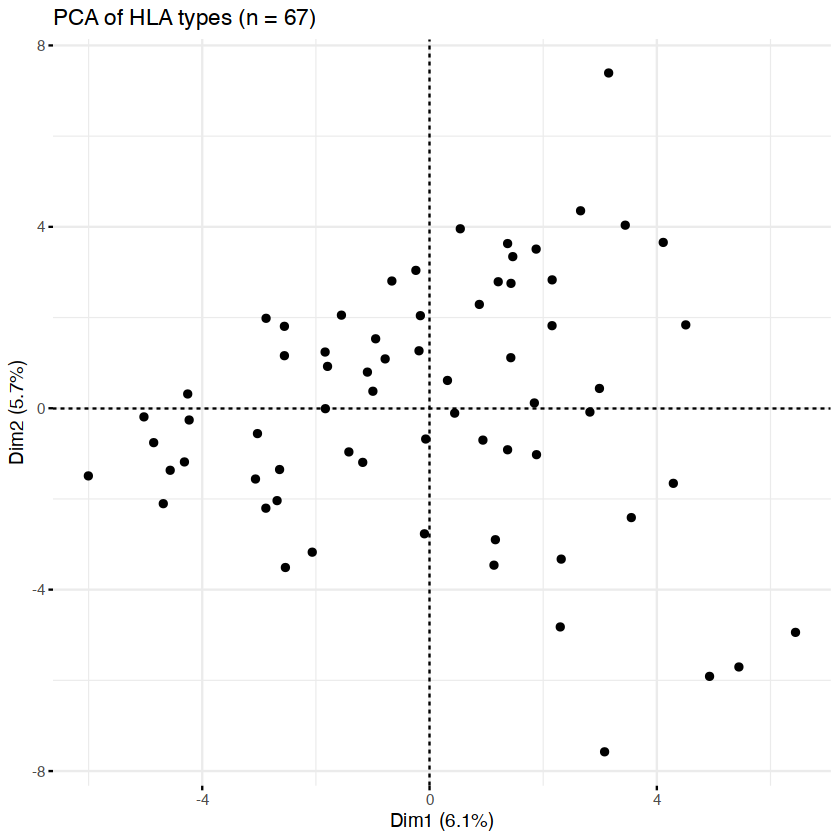

In [40]:
p0